# Exercices sur le CM 1 

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import ggplot as gg

## Echantillons binomiaux

Pour engendrer une suite de `N=1000` variables de Bernoulli indépendantes de  probabilité  de succès `p=.4`, on utilise le générateur `random.binom`  du module `numpy`, 

In [2]:
N,p,n = 1000,.4,1
s = np.random.binomial(n, p, N)
print(s.mean())

0.382


Les deux premiers arguments $n, p$ désignent les paramètres de la binomiale. 
Ici $n=1$. Le troisième argument `size` désigne la taille de l'échantillon désiré 
(attention, c'est la convention contraire à celle de R).

Quelle fonction de quel module invoquer
pour calculer la moyenne d'une séquence (tuple ou list) ?

Quel est le type/la classe de `s` ? 

La loi des grands nombres peut être illustrée dans ce contexte. On visualise $10$ trajectoires construites chacune sur $N=1000$  épreuves de Bernoulli. 
`reps` est un tableau de $10$  lignes et $N$  colonnes. 

In [3]:
reps = np.random.binomial(n=1,p=.4,size=(10,10000))
paths = reps.cumsum(axis=1)
normalized_paths = paths/range(1,paths.shape[1]+1)

`qplot` est une fonction du module `ggplot`.
On visualise ici l'évolution de l'estimation sur une suite lancers de pièces.   
La loi des grands nombres se manifeste : la trajectoire des estimées se rapproche de la valeur de $p$ (l'estimande).

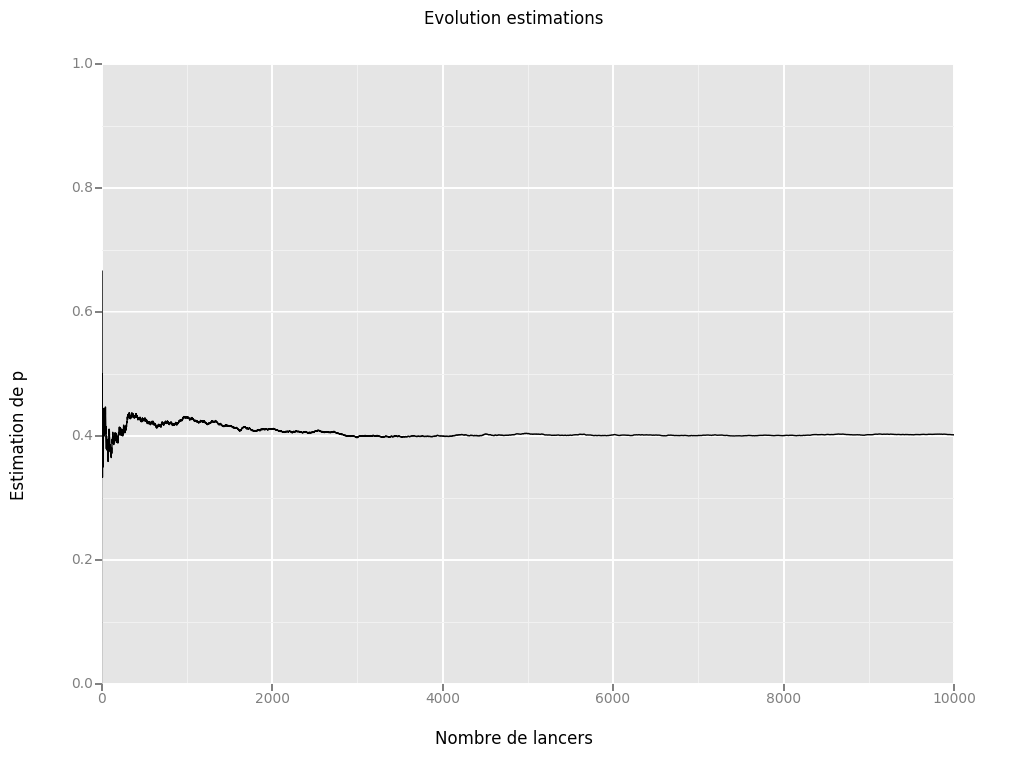

<ggplot: (277512445)>

In [4]:
gg.qplot(x=range(0,paths.shape[1]),y=normalized_paths[0,:],geom="line")+\
 gg.ylim(0,1)+gg.xlab("Nombre de lancers")+gg.ylab("Estimation de p")+\
 gg.ggtitle("Evolution estimations")

On peut superposer sur un même graphique plusieurs trajectoires.  
L'outil de construction de graphiques du module `ggplot` est la fonction `ggplot`.  
Cette fonction travaille sur un `DataFrame` du module `pandas`.  

Pour utiliser confortablement `ggplot` les colonnes du `DataFrame` doivent être nommées. Il semble que cela soit la seule manière de passer des arguments à `aes()`.

Une colonne supplémentaire est introduite pour symboliser le temps (taille de sous échantillon).

On utilise ici la construction Python appelée *list comprehension* pour réaliser ce qui est effectué avec des outils de programmation fonctionnelle en `R`. Ces outils de programmation fonctionnelle sont aussi disponibles en Python (`lambda, map, filter` et modules `functools`) mais ils sont sont moins pythonistes que les *list comprehension*. 

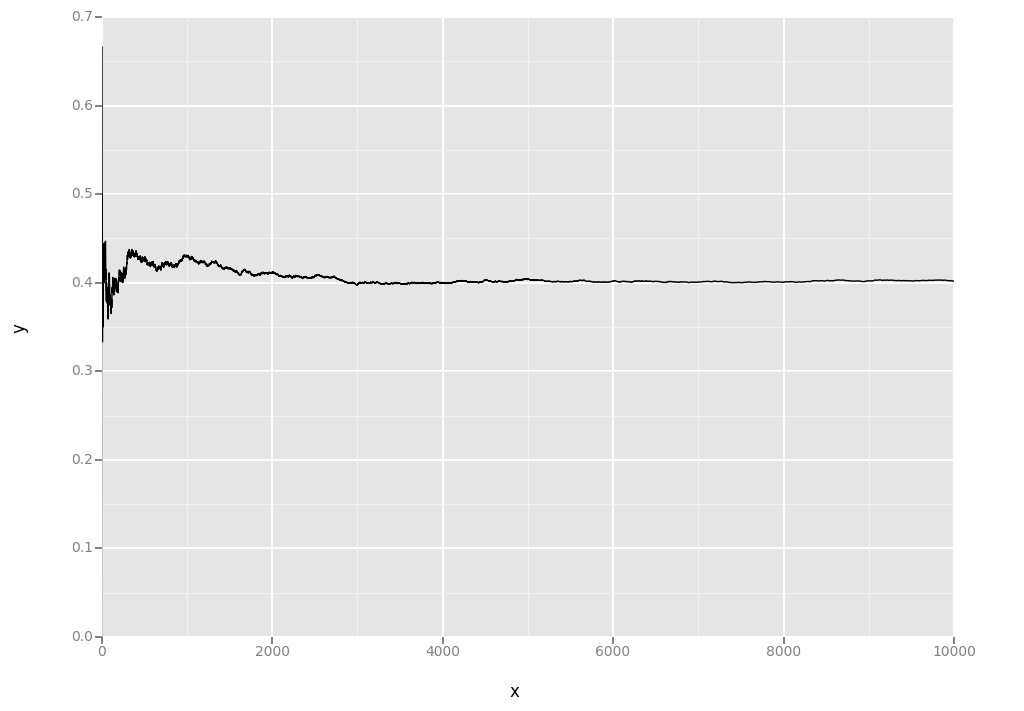

<ggplot: (277868110)>

In [5]:
foo = {str(i):normalized_paths[i,:] 
       for i in range(normalized_paths.shape[0])}
df = pd.DataFrame(foo)         # les clés du dictionnaire deviennent des noms de colonnes
df['10'] = range(df.shape[0])  # une colonne pour le temps
gg.qplot(x=df['10'],y=df['0'],geom="line")   

Pour superposer plusieurs trajectoires d'estimation sur le même graphique, utiliser la possiblilité d'ajouter des couches (*layers*) à un graphique.  
L'objet graphique `pl` est muni du `DataFrame` `df`. La première couche est associée à la colonne nommée `0` du `DataFrame`, elle est crée en même temps que l'objet `pl`. Les autres couches sont ajoutées par la boucle `for`. Elles correspondent aux colonnes `1`, `2`, `3` du `DataFrame`. A chaque couche correspond une géométrie, elle même définie par un paramètre `aesthetics` (qui précise la partie des données à utiliser).   

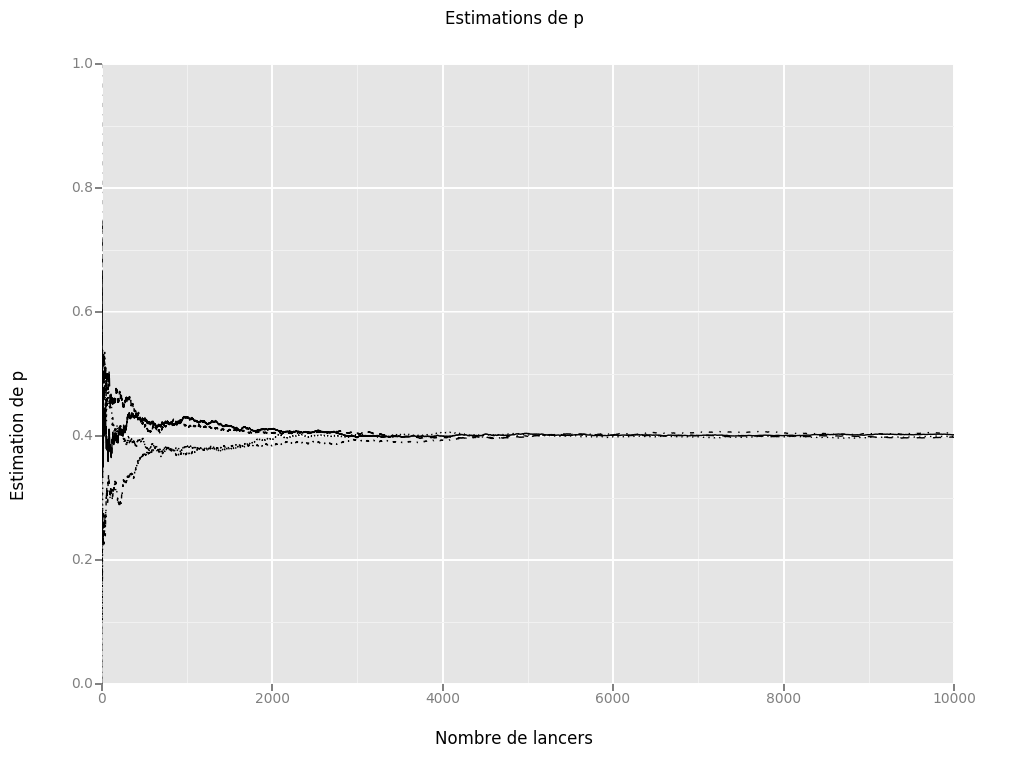

<ggplot: (-9223372036576665137)>

In [6]:
line_style = ('solid', 'dashed', 'dashdot', 'dotted')
pl = gg.ggplot(gg.aes(x="10",y="0"),data=df)+gg.geom_line()
for i in range(1,4):
    pl = pl + gg.geom_line(gg.aes(y=str(i)),linetype=line_style[i])
pl = pl + gg.ylim(0,1) + gg.xlab("Nombre de lancers") \
    + gg.ylab("Estimation de p") + gg.ggtitle("Estimations de p")
pl

## Histogramme des estimations d'un paramètre de Bernouilli

On calcule `1000` estimées elles-mêmes calculées à partir de `n=10000` lancers pseudo-aléatoires. La loi de l'estimateur est (au facteur 10000 près) une binomiale de paramètres `10000` et `.4`.  

L'histogramme présenté ici indique pour chaque *bin* le nombre de points de l'échantillon d'estimateurs situés dans ce *bin* (intervalle). L'hsitogramme peut être regardé comme un estimateur de densité constant par morceaux (si on normalise convenablement).



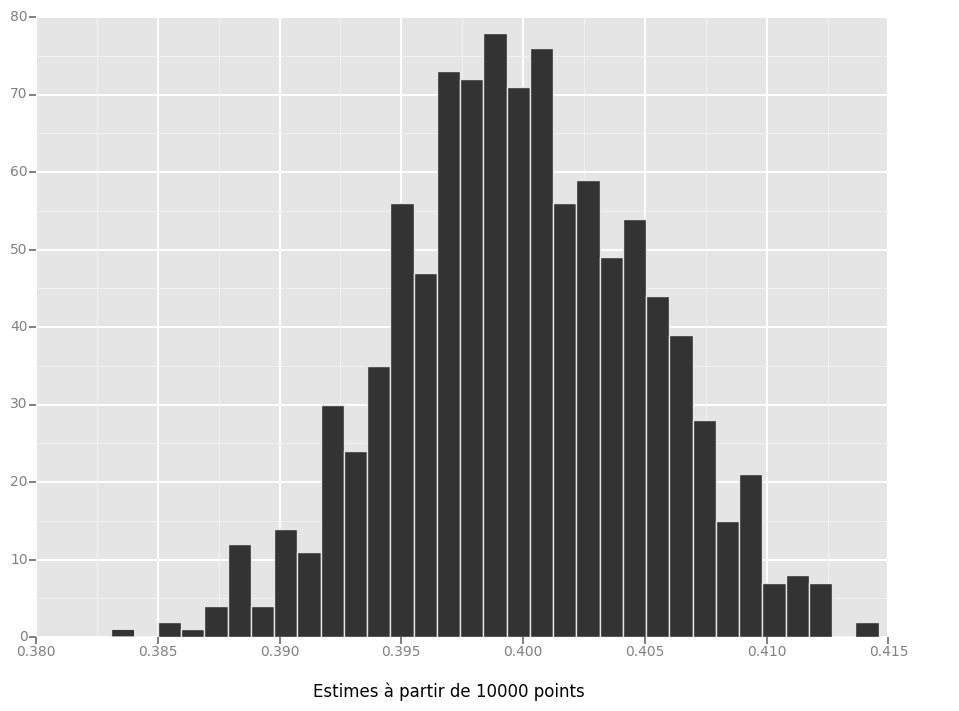

<ggplot: (-9223372036576352231)>

In [7]:
n,p,N=10000,.4,1000 
rs = {"sample" : np.random.binomial(n=n,p=p,size=N)/n} # 
df = pd.DataFrame(rs)
pl = gg.ggplot(gg.aes(x="sample"),data=df)+gg.geom_histogram(bins=round(N/(30))) 
pl = pl + gg.xlab("Estimes à partir de "+str(n)+" points")
pl

In [8]:
print("Moyenne : ", df["sample"].mean(),"\n","Ecart-type : ", np.sqrt(df["sample"].var())) 

Moyenne :  0.3999587 
 Ecart-type :  0.00511790164298


Si les $X_i$ sont des variables de Bernoulli indépendantes et si $Z=\sum_{i=1}^n X_i$ alors l'inégalité de Hoeffding implique  
$$ \mathbf{P} \left\{  |Z- \mathbf{E} Z| \geq \sqrt{\frac{n}{4\alpha}} \right\} \leq \alpha \, .  $$
On en déduit un intervalle de niveau de confiance $1-\alpha$:  

$$
\left[\widehat{\theta} - \sqrt{\frac{1}{4n\alpha}}, \widehat{\theta} + \sqrt{\frac{1}{4n\alpha}} \right] \, . 
$$

In [9]:
def cci(x, alpha=.05):
    """
        Intervalle de confiance pour l'estimation d'un paramètre de Bernoulli
        fondé sur l'inégalité de Chebychev
        
        cci(np.random.binomial(n=1,p=.4,size=10000))
    """
    return(np.array(x.mean()+(-1,1)/np.sqrt(4*alpha*len(x))))



On cherche ici à évaluer le taux de couverture de l'IC déduit de l'inégalité de Bienaymée-Chebychev lorsque la taille de l'échantillon n'est que $n=10000$, en visant un niveau de confiance $1-\alpha$ avec $\alpha=.25$. On constate que ce taux évalué à partir de $1000$ essais est largement supérieur au taux de couverture ciblé. Cet intervalle manque définitivement de précision.  

L'idée est de simuler une collection d'échantillons, de construire sur chacun des échantillons un intervalle de confiance et de calculer si le paramètre d'intérêt appartient à la région de confiance. 

In [10]:
n,p,N,alpha = 10000,.4,1000,.25 
rs = np.array([p<cci(np.random.binomial(1,.4,10000),alpha=alpha) for i in range(N)])
print("taux de couverture empirique de l'IC Chebychev :", sum(((1- rs[:,0]) * rs[:,1]))/N)

taux de couverture empirique de l'IC Chebychev : 0.956


### Calcul d'un intervalle de niveau de confiance $> 1- \alpha$ plus précis 

Si les $X_i$ sont des variables de Bernoulli indépendantes et si $Z=\sum_{i=1}^n X_i$ alors l'inégalité de Hoeffding implique  
$$ \mathbf{P} \left\{  |Z- \mathbf{E} Z| \geq \sqrt{(n/2) \log (2/\alpha)}\right\} \leq \alpha \, .  $$
On en déduit un intervalle de niveau de confiance $1-\alpha$
$$
\left[\widehat{\theta} - \sqrt{\frac{\log(2/\alpha)}{2n}}, \widehat{\theta} + \sqrt{\frac{\log(2/\alpha)}{2n}} \right] \, . 
$$
Cet intervalle est retourné par la fonction `hci`. 

In [11]:
def hci(x, alpha=.05):
    """
        Intervalle de confiance pour l'estimation d'un paramètre de Bernoulli
        fondé sur l'inégalité de Hoeffding
        
        hci(np.random.binomial(n=1,p=.4,size=10000))
    """
    return(x.mean()+np.sqrt(np.log(2/alpha)/(2*len(x)))*np.array([-1,1]))

On cherche ici à évaluer le taux de couverture de l'IC Hoeffding lorsque la taille de l'échantillon n'est que $N=$ `r N`. On constate que ce taux évalué à partir de $1000$ essais est supérieur de la valeur ciblée. L'intervalle de confiance construit ainsi est conservateur. Il manque de précision. 

In [12]:
n,p,N,alpha = 10000,.4,1000,.25 
rs = np.array([p<hci(sc.stats.bernoulli.rvs(p=p,size=n),alpha=alpha) for i in range(N)])
print("taux de couverture empirique de l'IC Hoeffding : ", sum(((1- rs[:,0]) * rs[:,1]))/N)


taux de couverture empirique de l'IC Hoeffding :  0.962


### Calcul d'un intervalle de niveau de confiance asymptotique $1-\alpha$.  


*Convention:* Pour $\alpha \in ]0,1[$, on note $z_{\alpha}$ le quantile d'ordre $1-\alpha$ de la gaussienne centrée réduite (standard), 

C'est la solution de l'équation en $x$:
$$
1-\alpha =  \int_{-\infty}^x \frac{\mathrm{e}^{-u^2/2}}{\sqrt{2\pi}} \mathrm{d}u \, . 
$$

Le  théorème central limite dans sa version la plus simple (De Moivre-Laplace) nous indique que 
si les $\widehat{\theta}_n$ sont distribués selon $P_\theta^{\otimes n}$, 
$$
\frac{\sqrt{n}}{\sqrt{\theta(1-\theta)}} \left( \widehat{\theta}_n -\theta\right) \rightsquigarrow \mathcal{N}(0,1) \, ,
$$
ce qui se traduit (entre autres) par la convergence simple des fonctions de répartitions, soit pour tout $\alpha \in ]0,1[$
$$
\lim_n \mathbf{P}_{\theta}^{\otimes n} \left\{ \frac{\sqrt{n}}{\sqrt{\theta(1-\theta)}} \left( \widehat{\theta}_n -\theta\right) \leq z_{\alpha}\right\} = 1-\alpha \, . 
$$
Le lemme de Slutsky, et le fait que $\widehat{\theta}_n/\theta$  converge en probabilité vers $1$ lorsque $n\to \infty$, permet d'écrire pour tout $\alpha \in ]0,1[$,
$$
\lim_n \mathbf{P}_{\theta}^{\otimes n} \left\{ \frac{\sqrt{n}}{\sqrt{\widehat{\theta}(1-\widehat{\theta})}} \left( \widehat{\theta}_n -\theta\right) \leq z_{\alpha}\right\} = 1-\alpha \, . 
$$
Cela conduit à proposer l'intervalle de niveau de confiance asymptotique $1-\alpha$ :
$$
\left[\widehat{\theta} - z_{\alpha/2}\sqrt{\frac{\widehat{\theta}(1-\widehat{\theta})}{n}}, \widehat{\theta} + z_{\alpha/2}\sqrt{\frac{\widehat{\theta}(1-\widehat{\theta})}{n}}\right] \, . 
$$
Cet intervalle de confiance est calculé par la fonction


In [13]:
def acifunction(x, alpha=.05):
    """
        intervalles de confiance asymptotiquement exact 
        pour le parametre d'une loi de Bernoulli
    """
    zhalfalpha = sc.stats.norm.ppf(1-alpha/2,0,1)
    return(x.mean()+np.sqrt(np.var(x))*zhalfalpha*np.array([-1,1])/np.sqrt(len(x)))

In [14]:
n,p,N,alpha = 10000,.4,1000,.05 
rs = np.array([p<acifunction(sc.stats.bernoulli.rvs(p=p,size=n),alpha=alpha) for i in range(N)])
print("Taux de couverture empirique de l'IC asymptotique : ", sum(((1- rs[:,0]) * rs[:,1]))/N)

Taux de couverture empirique de l'IC asymptotique :  0.947


On cherche ici à évaluer le taux de couverture de l'ICA lorsque la taille de l'échantillon n'est que $N=30$. On constate que ce taux évalué à partir de $1000$ essais est voisin de la valeur ciblée. 

In [15]:
n = 30
rs = np.array([p<acifunction(sc.stats.bernoulli.rvs(p=p,size=n),alpha=alpha) for i in range(N)])
print("Taux de couverture empirique de l'IC asymptotique : ", sum(((1- rs[:,0]) * rs[:,1]))/N)

Taux de couverture empirique de l'IC asymptotique :  0.926


### Une région de confiance exacte.

Dans cette section, on note $\operatorname{qb}(\alpha,n,\theta)$ le quantile d'ordre $1-\alpha$ de la loi binomiale de paramètres $n,\theta$ (cela correspond à la fonction `qbinom()`  de `R` ou à la fonction `scipy.stats.binom.ppf()` du module `SciPy`). On définit la région empirique 
$$
\left\{\theta' :  \operatorname{qb}(\alpha/2,n,\theta') \leq  n\widehat{\theta}_n \leq   \operatorname{qb}(1-\alpha/2,n,\theta')\right\}
$$
On vérifie que cette région est un intervalle (exercice) délimité par  
$$
\underline{\theta} = \inf \{ \theta' : \operatorname{qb}(1-\alpha/2,n,\theta')\geq n\widehat{\theta}_n \}
$$
et 
$$
\overline{\theta} = \sup \{ \theta' : \operatorname{qb}(\alpha/2,n,\theta')\leq n\widehat{\theta}_n \} \,.
$$
C'est aussi une région de niveau de confiance $1-\alpha$.


In [16]:
def eci(x, alpha=.05):
    """
        
    """
    hattheta = sum(x)
    foo = lambda theta : sc.stats.binom.ppf(q=alpha/2,n=len(x),p=theta)-hattheta
    overtheta = sc.optimize.brentq(f=foo,a=.01,b=.99,maxiter = 100,full_output=False)
    foobar =  lambda theta : sc.stats.binom.ppf(q=1-alpha/2,n=len(x),p=theta)-hattheta
    undertheta = sc.optimize.brentq(f=foobar,a=.01,b=.99,maxiter = 100,full_output=False)
    return np.array([undertheta,overtheta])

On cherche ici à évaluer le taux de couverture de l'IC *exacts* lorsque la taille de l'échantillon n'est que $N=$ `r N<-1000`. On constate que ce taux évalué à partir de $10000$ essais est voisin de la valeur ciblée (on peut vérifier via les inégalités de Berry-Esseen que l'écart est majoré par une quantité qui dépend de $\theta$  et de $1/\sqrt{n}$). 

In [17]:
n,N,p,alpha = 100,1000,.4,.05
rs = np.array([p<eci(sc.stats.bernoulli.rvs(p=p,size=n),alpha=alpha) 
               for i in range(N)])
print("taux de couverture empirique de l'IC exact : ", sum(((1- rs[:,0]) * rs[:,1]))/N)


taux de couverture empirique de l'IC exact :  0.953



Cet intervalle de confiance est plus couteux à calculer que les précédents. La fonction qui calcule cet intervalle 
de confiance doit définir deux fonctions locales qui sont confiées à une fonction `uniroot`. 

## Tester 

On veut tester l'hypothèse nulle ($H_0$) $p \leq p_0 =.5$  contre l'alternative ($H_1$)  $p > .5$. 
Une hypothèse est une collection de loi de probabilités. 

Un test binaire est une fonction des données qui vaut $1$ (on rejette l'hypothèse nulle $H_0$) ou $0$ (on en rejette pas $H_0$)

Erreur de première espèce 


Erreur de seconde espèce


Test de rapport de vraisemblance.

Le rapport de vraisemblance est en fait une fonction de $\sum_{i=1}^n X_i/n=  \widehat{\theta}_n$ (ce n'est pas du tout une simple coïncidence). 
$$
\left(\frac{1-\theta_1}{1-\theta_0}\right)^n \left(\frac{\theta_1(1-\theta_0)}{\theta_0(1-\theta_1)} \right)^{n \widehat{\theta}_n}
$$
Comparer le rapport de vraisemblance à un seuil, c'est équivalent à comparer  $\widehat{\theta}_n$ à un seuil, 
à rejeter $H_0$ lorsque $\widehat{\theta}_n$  dépasse le seuil, à ne pas rejeter $H_0$ si $\widehat{\theta}_n$  ne dépasse pas le seuil. 

### Visualisation de la dépendance puissance/niveau

Pour une grille de seuils (`thresholds`), on évalue niveau (`underH0`) et puissance (`underH1`) pour différentes tailles d'échantillon (`500,1000`). Sur un même graphique on représente la courbe niveau/puissance pour ces trois tailles d'échantillon. Pour chaque courbe, le meilleur compromis erreur de première espèce/erreur de seconde espèce est la distance $\ell_1$ au point $(0,1)$. On constate (sans surprise) que cette distance diminue lorsque la taille de l'échantillon augmente. 


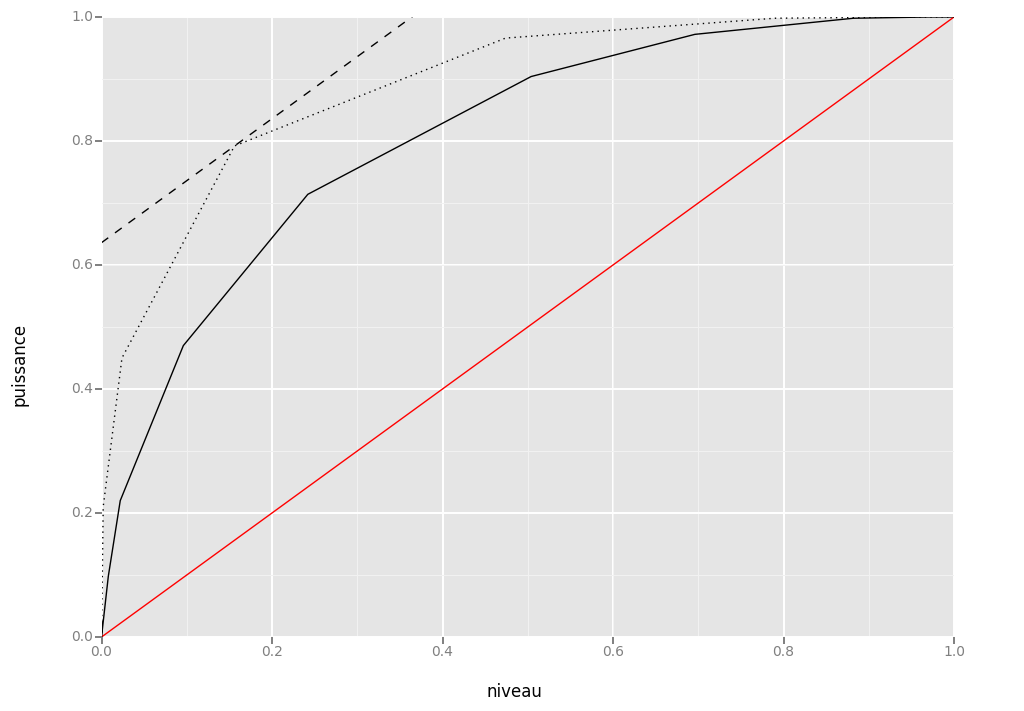

<ggplot: (-9223372036576030958)>

In [18]:
theta0,theta1,N,n = .5,.52,500,1000
thresholds = np.arange(.01,1,.01)

underH0 = np.array([np.array([t < data  for data in sc.stats.binom.rvs(n=n,p=theta0,size=N)/n]).mean() 
                     for t in thresholds])
underH1 = np.array([np.array([t < data  for data in sc.stats.binom.rvs(n=n,p=theta1,size=N)/n]).mean()
                     for t in thresholds])

n = 2000
underH0bis = np.array([np.array([t < data  for data in sc.stats.binom.rvs(n=n,p=theta0,size=N)/n]).mean() 
                     for t in thresholds])
underH1bis = np.array([np.array([t < data  for data in sc.stats.binom.rvs(n=n,p=theta1,size=N)/n]).mean()
                     for t in thresholds])

df = pd.DataFrame({"underH0" : underH0, 
                   "underH1" : underH1, 
                   "underH0bis" : underH0bis , 
                   "underH1bis" : underH1bis})

p = gg.ggplot(gg.aes(x="underH0",y="underH1"),data=df) + gg.geom_line()
p = p + gg.xlab("niveau") + gg.ylab("puissance")
p = p + gg.geom_abline(intercept=0,slope=1,color="red")
p = p + gg.geom_line(gg.aes(x="underH0bis",y="underH1bis"),linetype='dotted')  

compromis =[min(1+underH0-underH1), min(1+underH0bis-underH1bis)]

p + gg.geom_abline(slope=1,intercept=1-compromis[1],linetype="dashed") +gg.ylim(0,1)+gg.xlim(0,1)



## Outils Python utiles 

### Dans le module `numpy`

### Dans `scipy`

[http://docs.scipy.org/doc/scipy/reference/](http://docs.scipy.org/doc/scipy/reference/)

### Dans `Pandas`

### Dans `ggplot`

### Pour naviguer entre Python et R 

[http://mathesaurus.sourceforge.net/r-numpy.html](http://mathesaurus.sourceforge.net/r-numpy.html)